In [1]:
# Cargar librerias y modelos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]  #por defecto las figuras se displayan 10 pulgadas de ancho y 8 de alto

from sklearn.ensemble import AdaBoostClassifier   # Ensamble AdaBoost para regresion
from sklearn.ensemble import GradientBoostingClassifier   # Ensamble Gradient Boosting para regresion
from sklearn.ensemble import RandomForestClassifier   # Ensamble RandomForest para regresion
from sklearn.ensemble import ExtraTreesClassifier     # Ensamble ExtraTrees para regresion

from sklearn.linear_model import LogisticRegression # para usar modelos de regresion logistica
from sklearn.tree import DecisionTreeClassifier     # para usar modelos de tipo arboles de decision
from sklearn.neighbors import KNeighborsClassifier  # para modelos  Knn
from sklearn.svm import SVC   # para modelos SVM

from sklearn.model_selection import train_test_split  # para partir los datos en conjuntos de entrenamiento y validacion
from sklearn.model_selection import KFold  # para partir la data en k-folds
from sklearn.model_selection import cross_val_score   # para evaluar algoritmos en cross validacion

from sklearn.metrics import accuracy_score, balanced_accuracy_score   # para manejar metricas de desempeño
from sklearn.metrics import classification_report  # para hacer reportes de resultados de clasificacion
from sklearn.metrics import confusion_matrix  # para manejar matrices de confusion

In [2]:
import warnings

# Ignorar todos los warnings
warnings.filterwarnings("ignore")

# Cargar los datos

In [3]:
data = pd.read_csv('Data_clust_oficial.csv')

In [4]:
data.head(3)

,Unnamed: 0,YEAR,UBIGEO,DOMINIO,ESTRATO,Registro_SUNARP_SI,Registro_SUNARP_NO,Asistencia_Tecnica_SI,Asistencia_Tecnica_NO,Asistencia_Tecnica_NOSABE,...,Max_Mag,Categoria_I-1,Categoria_I-2,Categoria_I-3,Categoria_I-4,Proyectos_inversion,ZONA,cluster_std,latitud,longitud
0,0,2018,10202,7,7,0,0,0,24,0,...,0.0,13.0,3.0,3.0,0.0,0.0,2.0,1,-5.4164,-78.4378
1,1,2018,10201,7,4,13,9,6,45,12,...,0.0,7.0,0.0,2.0,0.0,0.0,2.0,1,-5.6389,-78.5311
2,2,2018,10203,7,6,2,3,0,21,2,...,0.0,4.0,1.0,1.0,0.0,0.0,2.0,1,-5.6750,-78.4231


In [5]:
data.YEAR.unique()

array([2018, 2021, 2020, 2019, 2015, 2017, 2016, 2022, 2014, 2013, 2012],
      dtype=int64)

In [6]:
data.YEAR.isnull().sum()

0

In [106]:
#data=data[data['YEAR']==2018]

In [8]:
data.columns

Index(['Unnamed: 0', 'YEAR', 'UBIGEO', 'DOMINIO', 'ESTRATO',
       'Registro_SUNARP_SI', 'Registro_SUNARP_NO', 'Asistencia_Tecnica_SI',
       'Asistencia_Tecnica_NO', 'Asistencia_Tecnica_NOSABE', 'Licencia_SI',
       'Licencia_NO', 'Licencia_NOSABE', 'Tipo_casa_Independiente',
       'Tipo_casa_Departamento', 'Tipo_casa_Quinta', 'Tipo_casa_Vecindad',
       'Tipo_casa_Choza', 'Tipo_casa_Improvisada', 'Tipo_casa_No_habitable',
       'Tipo_casa_Otro', 'Pared_Ladrillo', 'Pared_Piedra_sillar',
       'Pared_Adobe', 'Pared_Tapia', 'Pared_Quincha', 'Pared_Piedra_barro',
       'Pared_Madera', 'Pared_Tripley', 'Piso_MaderaPulida',
       'Piso_LaminasAsfalticas', 'Piso_Losetas', 'Piso_Madera', 'Piso_Cemento',
       'Piso_Tierra', 'Piso_Otro', 'Techo_Concreto', 'Techo_Madera',
       'Techo_Tejas', 'Techo_Calamina', 'Techo_Caña', 'Techo_Triplay',
       'Techo_Paja', 'Techo_Otro', 'Nivel_Casa_Alquilada',
       'Nivel_Casa_PropiaPagada', 'Nivel_Casa_PropiaInvasion',
       'Nivel_Casa_Pro

# Caracterizacion de los Grupos

Selecionamos las Caracteristicas mas interesantes para su posterior analisis de su comportamiento en los tres grupos formados

Proyectos de Invesion, Conteo de Viviendas, Zona, 

- Proyectos de Invesion: Conteo de todos los proyectos financiados por FONDES por cada RPDA
- Dominio: Dominio geográfico de la zona de la viviend: 1(Costa Norte), 2(Costa Centro), 3(Costa Sur), 
        4(Sierra Norte), 5(Sierra Centro), 6(Sierra Sur), 7(Selva), 8(Lima Metropolitana) 
- Tipo_Vivienda: 1(Casa independiente), 2(Departamento en edificio), 3(Vivienda en quinta), 4(Vivienda en casa de vecindad), 5(Choza), 6(Vivienda improvisada), 7(Local no destinado para habitación humana)
- Nivel_propiedad_vivienda: La vivienda hasta qué nivel es de su propiedad:1(alquilada), 2(propi, pago completo), 3(propia, invasión), 4(propia, a crédito), 5(cedida por trabajo), 6(cedida), 7(Otra)
- Pared_material: Material predominante de las paredes: 1(ladrillo), 2(piedra, sillar), 3(adobe), 4(tapia), 5(Quincha: Caña con Barro), 6(Piedra con barro), 7(Madera), 8(Tripley), 9(Otro)
- Piso_material: Material predominante de los pisos: 1(madera pulida), 2(láminas asfálticas), 3(losetas), 4(madera), 5(Cemento), 6(Tierra), 7(Otro)
- Techo_material: Material predominante de los techos: 1(concreto armado), 2(madera), 3(tejas), 4(calamina), 5(Triplay), 6(Paja), 7(Otro)


In [9]:
data.Proyectos_inversion.unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  8., 12.,  9.,  7., 15., 10.,  6.,
       11., 14., 20., 16., 13.])

In [10]:
data.DOMINIO.unique()

array([7, 4, 5, 2, 6, 3, 1, 8], dtype=int64)

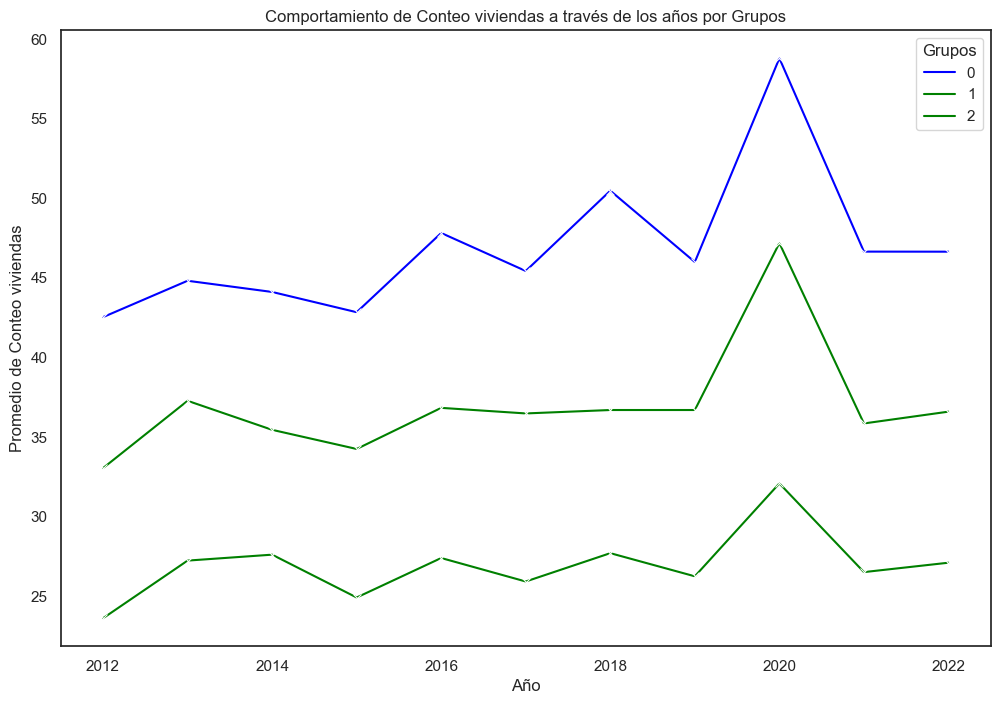

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que df es tu DataFrame
# Ajusta el nombre de las columnas según tu caso
# Agrupar por YEAR y cluster_std y calcular el valor promedio
df_promedio = data.groupby(['YEAR', 'cluster_std'])['Conteo_viviendas'].mean().reset_index()

# Configurar el estilo de seaborn
sns.set(style="white")

# Definir colores para cada cluster_std
colores = {0: 'blue', 1: 'green', 2: 'green'}  # Cambia 'orange' por el color que prefieras para los clusters 1 y 2

sns.lineplot(x='YEAR', y='Conteo_viviendas', hue='cluster_std', data=df_promedio, marker='x', palette=colores)

# Añadir título y etiquetas a los ejes
plt.title('Comportamiento de Conteo viviendas a través de los años por Grupos')
plt.xlabel('Año')
plt.ylabel('Promedio de Conteo viviendas')

# Mostrar la leyenda
plt.legend(title='Grupos')

# Mostrar el gráfico
plt.show()

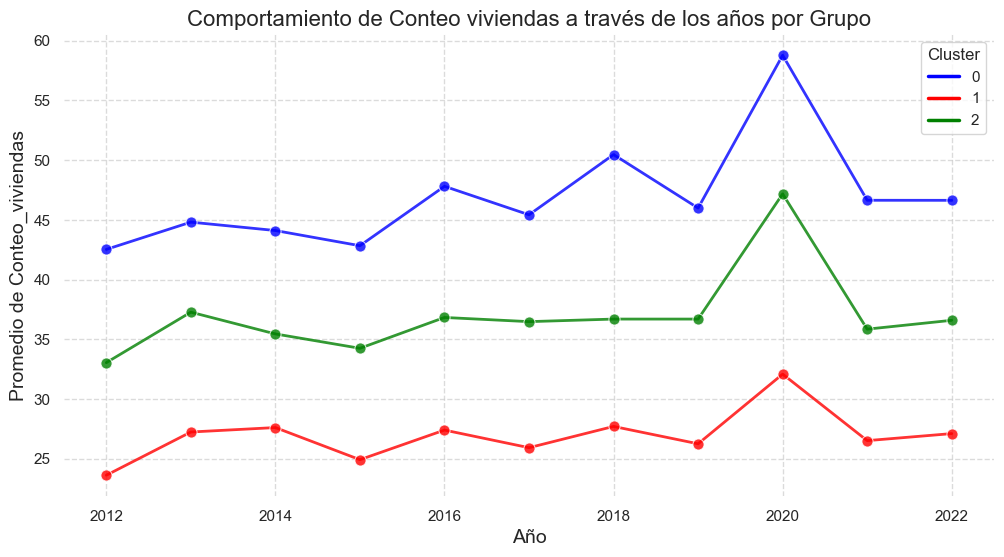

In [12]:
df_promedio = data.groupby(['YEAR', 'cluster_std'])['Conteo_viviendas'].mean().reset_index()

# Configurar el estilo de seaborn
sns.set(style="whitegrid", palette="deep")  # Cambiado a 'whitegrid' para añadir una rejilla y paleta de colores 'deep'

# Definir colores para cada cluster_std
colores = {0: 'blue', 1: 'red', 2: 'green'}  # Cambia 'orange' por el color que prefieras para los clusters 1 y 2

# Ajustes estéticos
sns.set_context("notebook", rc={"lines.linewidth": 2.5})  # Cambiar el contexto y el grosor de las líneas

# Crear un gráfico de líneas para cada cluster_std
plt.figure(figsize=(12, 6))
ax = sns.lineplot(x='YEAR', y='Conteo_viviendas', hue='cluster_std', data=df_promedio, 
                  marker='o', palette=colores, linewidth=2, markersize=8, alpha=0.8)

# Añadir título y etiquetas a los ejes
plt.title('Comportamiento de Conteo viviendas a través de los años por Grupo', fontsize=16)
plt.xlabel('Año', fontsize=14)
plt.ylabel('Promedio de Conteo_viviendas', fontsize=14)

# Mostrar la leyenda
plt.legend(title='Cluster')

# Ajustes adicionales
ax.set_facecolor('white')  # Fondo blanco para la gráfica
plt.grid(True, linestyle='--', alpha=0.7)  # Rejilla punteada
sns.despine(left=True, bottom=True)  # Quitar bordes izquierdo y inferior

# Mostrar el gráfico
plt.show()

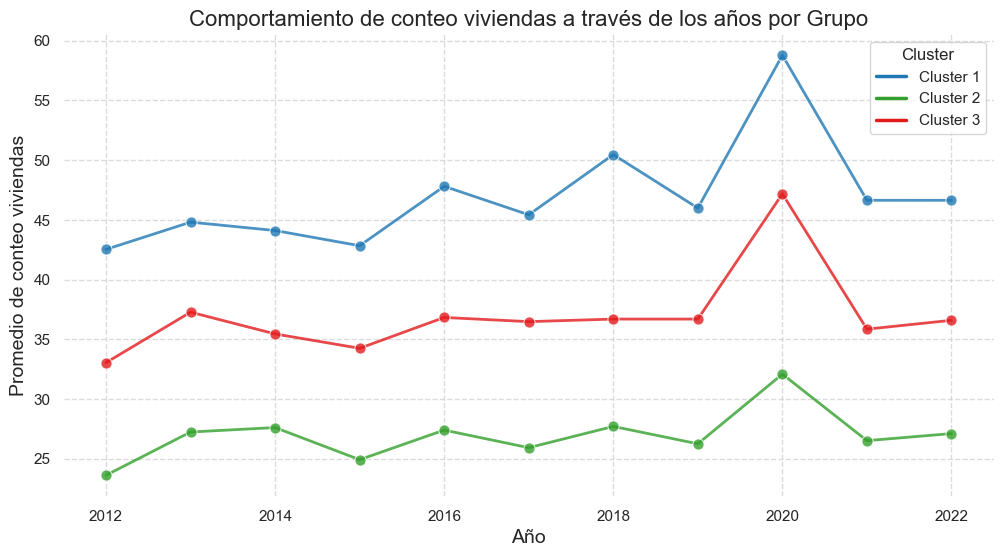

In [243]:
# Definir colores para cada cluster_std
colores = {'Cluster 1': '#1f78b4', 'Cluster 2': '#33a02c', 'Cluster 3': '#e31a1c'}

# Ajustes estéticos
sns.set_context("notebook", rc={"lines.linewidth": 2.5})  # Cambiar el contexto y el grosor de las líneas

# Crear un gráfico de líneas para cada cluster_std
plt.figure(figsize=(12, 6))
ax = sns.lineplot(x='YEAR', y='Conteo_viviendas', hue='cluster_std', data=df_promedio, 
                  marker='o', palette=colores, linewidth=2, markersize=8, alpha=0.8)

# Añadir título y etiquetas a los ejes
plt.title('Comportamiento de conteo viviendas a través de los años por Grupo', fontsize=16)
plt.xlabel('Año', fontsize=14)
plt.ylabel('Promedio de conteo viviendas', fontsize=14)

# Mostrar la leyenda
plt.legend(title='Cluster')

# Ajustes adicionales
ax.set_facecolor('white')  # Fondo blanco para la gráfica
plt.grid(True, linestyle='--', alpha=0.7)  # Rejilla punteada
sns.despine(left=True, bottom=True)  # Quitar bordes izquierdo y inferior


plt.savefig('vivienda_anio.png', bbox_inches='tight')

# Mostrar el gráfico
plt.show()

In [182]:
# Creamos una nueva columna 'Region' que agrupa las zonas según tu criterio
df['Region'] = df['DOMINIO'].map({
    1: 'Costa',
    2: 'Costa',
    3: 'Costa',
    4: 'Sierra',
    5: 'Sierra',
    6: 'Sierra',
    7: 'Selva',
    8: 'Lima Metropolitana'
})

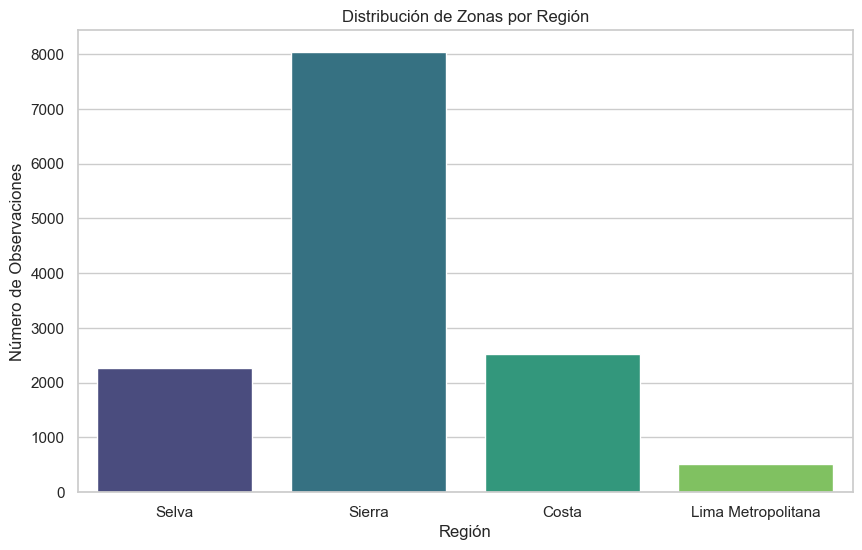

In [183]:
# Configurar el estilo de seaborn
sns.set(style="whitegrid")

# Crear el gráfico de distribución
plt.figure(figsize=(10, 6))
sns.countplot(x='Region', data=df, palette='viridis')  # Puedes ajustar la paleta de colores según tu preferencia

# Añadir título y etiquetas a los ejes
plt.title('Distribución de Zonas por Región')
plt.xlabel('Región')
plt.ylabel('Número de Observaciones')

# Mostrar el gráfico
plt.show()

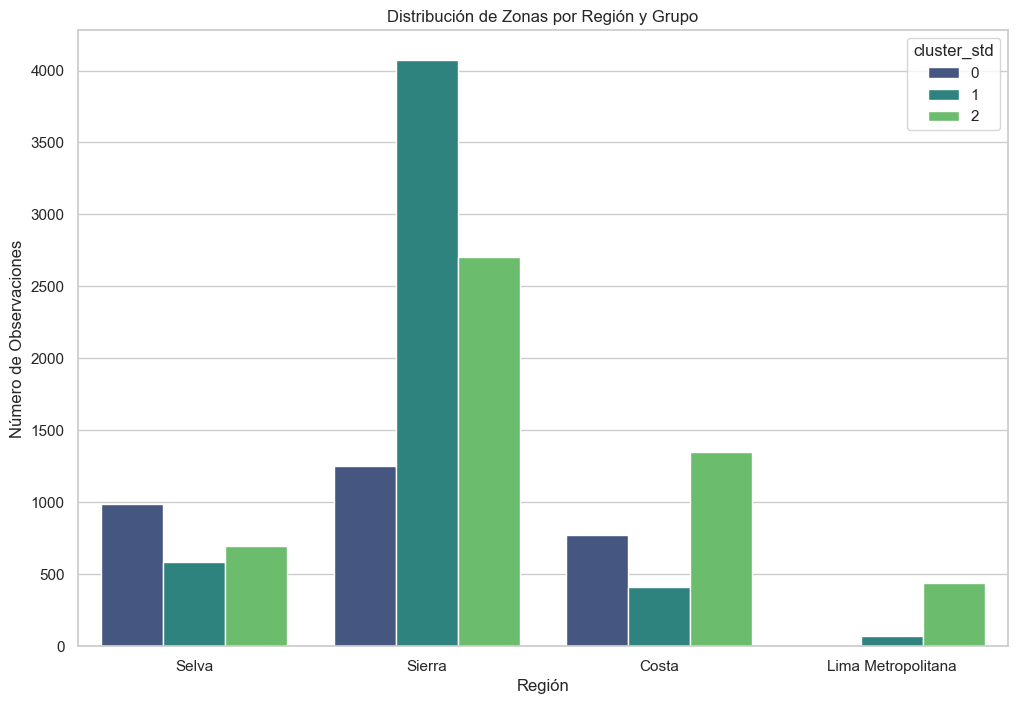

In [184]:
# Configurar el estilo de seaborn
sns.set(style="whitegrid")

# Crear el gráfico de distribución con distinción por grupos
plt.figure(figsize=(12, 8))
sns.countplot(x='Region', hue='cluster_std', data=df, palette='viridis')  # Ajusta la paleta de colores según tu preferencia

# Añadir título y etiquetas a los ejes
plt.title('Distribución de Zonas por Región y Grupo')
plt.xlabel('Región')
plt.ylabel('Número de Observaciones')

# Mostrar el gráfico
plt.show()

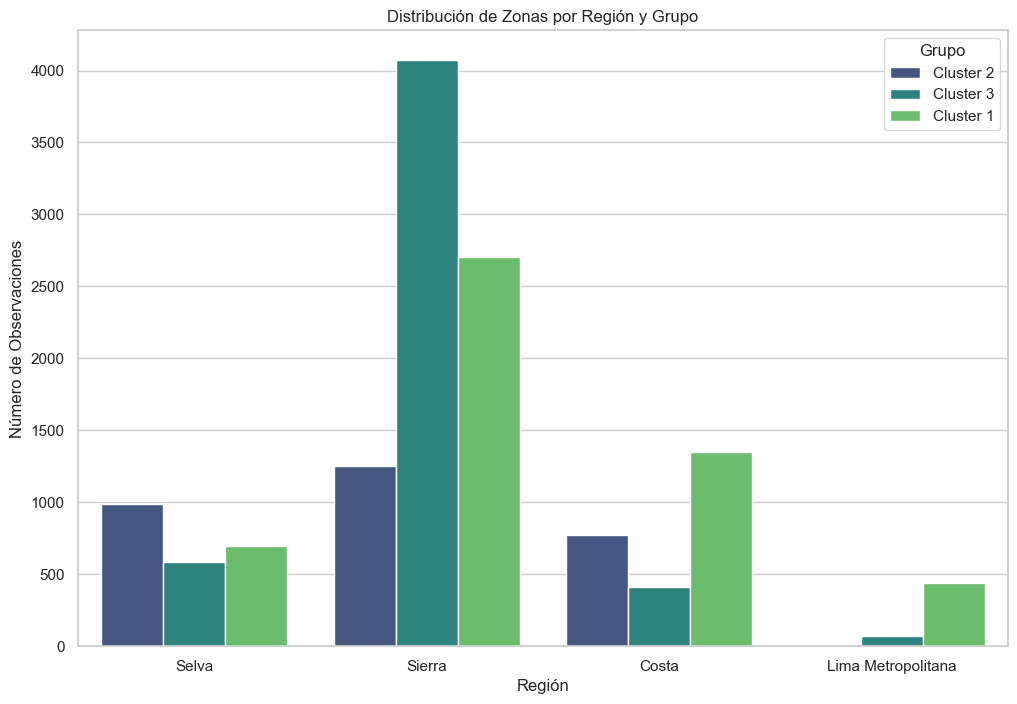

In [244]:
# Configurar el estilo de seaborn
sns.set(style="whitegrid")

# Crear el gráfico de distribución con distinción por grupos
plt.figure(figsize=(12, 8))
ax = sns.countplot(x='Region', hue='cluster_std', data=df, palette='viridis')  # Ajusta la paleta de colores según tu preferencia

# Mapear los nombres de la leyenda
leyenda_dict = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3'}
leyenda_labels = [leyenda_dict[label] for label in df['cluster_std'].unique()]

# Añadir título y etiquetas a los ejes
plt.title('Distribución de Zonas por Región y Grupo')
plt.xlabel('Región')
plt.ylabel('Número de Observaciones')

# Modificar la leyenda
ax.legend(title='Grupo', labels=leyenda_labels)

# Mostrar el gráfico
plt.show()

In [249]:
df_percentages.head()

,Region,cluster_std,Counts,Percentage
0,Costa,0,771,30.486358
1,Costa,1,411,16.251483
2,Costa,2,1347,53.262159
3,Lima Metropolitana,1,72,14.007782
4,Lima Metropolitana,2,442,85.992218


In [250]:
mapeo_grupos = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3'}

# Agregar la columna "Grupo" utilizando el mapeo
df_percentages['Grupo'] = df_percentages['cluster_std'].map(mapeo_grupos)

In [251]:
df_percentages.head()

,Region,cluster_std,Counts,Percentage,Grupo
0,Costa,0,771,30.486358,Cluster 1
1,Costa,1,411,16.251483,Cluster 2
2,Costa,2,1347,53.262159,Cluster 3
3,Lima Metropolitana,1,72,14.007782,Cluster 2
4,Lima Metropolitana,2,442,85.992218,Cluster 3


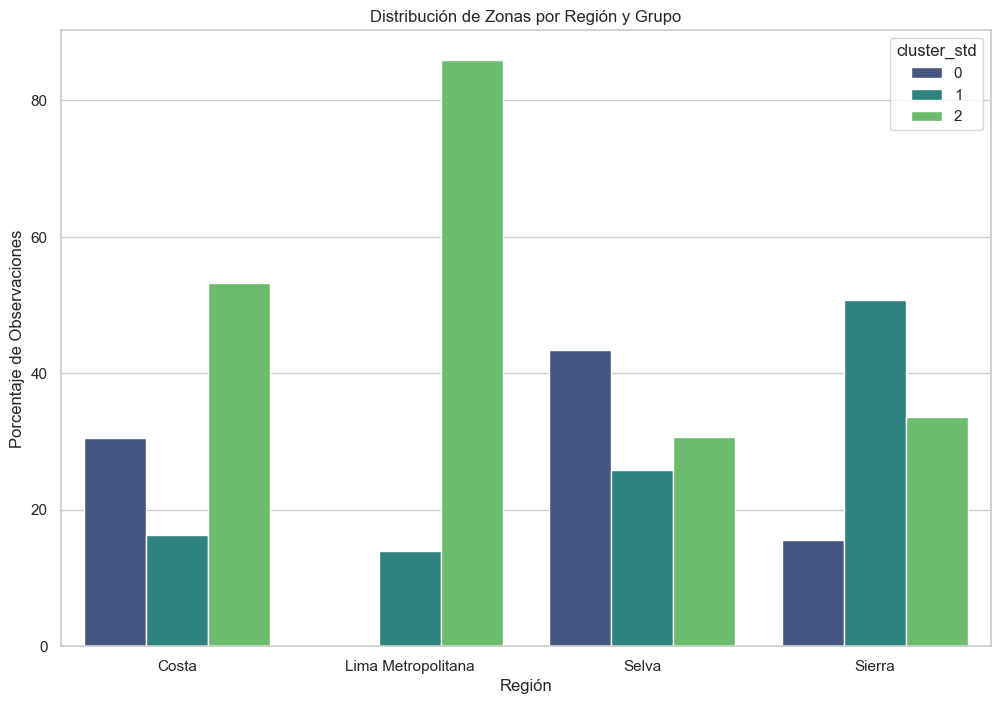

In [245]:
# Configurar el estilo de seaborn
sns.set(style="whitegrid")

# Calcular los porcentajes por cada grupo y región
df_percentages = df.groupby(['Region', 'cluster_std']).size().reset_index(name='Counts')
df_percentages['Percentage'] = df_percentages.groupby('Region')['Counts'].transform(lambda x: x / x.sum() * 100)

# Crear el gráfico de distribución con distinción por grupos
plt.figure(figsize=(12, 8))
sns.barplot(x='Region', y='Percentage', hue='Grupo', data=df_percentages, palette='viridis')


# Añadir título y etiquetas a los ejes
plt.title('Distribución de Zonas por Región y Grupo')
plt.xlabel('Región')
plt.ylabel('Porcentaje de Observaciones')



# Mostrar el gráfico
plt.show()

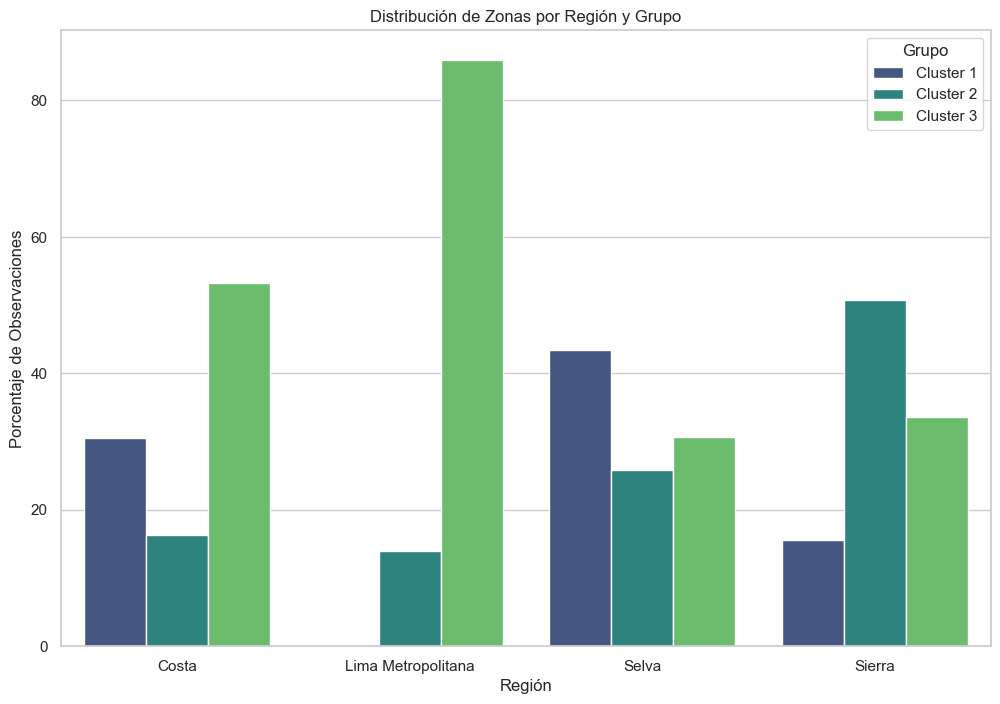

In [253]:
# Crear el gráfico de distribución con distinción por grupos
plt.figure(figsize=(12, 8))
sns.barplot(x='Region', y='Percentage', hue='Grupo', data=df_percentages, palette='viridis')


# Añadir título y etiquetas a los ejes
plt.title('Distribución de Zonas por Región y Grupo')
plt.xlabel('Región')
plt.ylabel('Porcentaje de Observaciones')


plt.savefig('zonas_re.png', bbox_inches='tight')
# Mostrar el gráfico
plt.show()

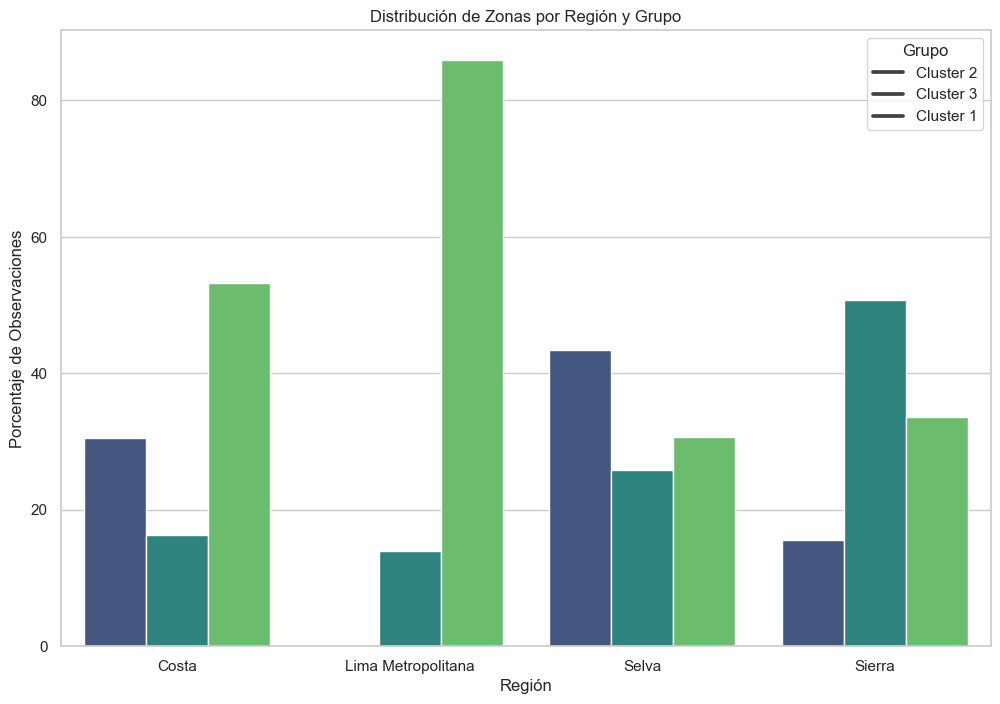

In [246]:
# Configurar el estilo de seaborn
sns.set(style="whitegrid")

# Calcular los porcentajes por cada grupo y región
df_percentages = df.groupby(['Region', 'cluster_std']).size().reset_index(name='Counts')
df_percentages['Percentage'] = df_percentages.groupby('Region')['Counts'].transform(lambda x: x / x.sum() * 100)

# Crear el gráfico de distribución con distinción por grupos
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Region', y='Percentage', hue='cluster_std', data=df_percentages, palette='viridis')

# Mapear los nombres de la leyenda
leyenda_dict = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3'}
leyenda_labels = [leyenda_dict[label] for label in df['cluster_std'].unique()]

# Añadir título y etiquetas a los ejes
plt.title('Distribución de Zonas por Región y Grupo')
plt.xlabel('Región')
plt.ylabel('Porcentaje de Observaciones')

# Modificar la leyenda
ax.legend(title='Grupo', labels=leyenda_labels)

# Mostrar el gráfico
plt.show()

In [200]:
df.Tipo_Vivienda_6.unique()

array([0, 1, 2, 3, 5, 4, 7, 9, 6], dtype=int64)

In [187]:
# Analizar el Tipo de vivienda
df['Tipo_Vivienda_Agrupado'] = df[['Tipo_Vivienda_1', 'Tipo_Vivienda_2', 'Tipo_Vivienda_3', 
                                   'Tipo_Vivienda_4', 'Tipo_Vivienda_5', 'Tipo_Vivienda_6', 'Tipo_Vivienda_7', 
                                   'Tipo_Vivienda_8']].sum(axis=1)

In [188]:
df['Tipo_Vivienda_Agrupado'] = df['Tipo_Vivienda_Agrupado'].map({
    1: 'Casa',
    2: 'Departamento',
    3: 'Vivienda Colectiva',
    4: 'Vivienda Colectiva',
    5: 'Improvisada',
    6: 'Improvisada',
    7: 'Otro'
})

In [201]:
df.Tipo_Vivienda_6.unique()

array([0, 1, 2, 3, 5, 4, 7, 9, 6], dtype=int64)

In [190]:
cantidad_nan = df['Tipo_Vivienda_Agrupado'].isna().sum()

print(f"La cantidad de registros NaN en 'Tipo_Vivienda_Agrupado' es: {cantidad_nan}")

La cantidad de registros NaN en 'Tipo_Vivienda_Agrupado' es: 11295


Queda en Stand By por el momento

Analicemos por la peligrosidad de la zona

In [204]:
data.ZONA.unique()

array([ 2.,  3.,  4.,  1., nan])

In [209]:
data.cluster_std.unique()

array([1, 2, 0], dtype=int64)

In [205]:
cantidad_nan = data['ZONA'].isna().sum()

print(f"La cantidad de registros NaN en 'Tipo_Vivienda_Agrupado' es: {cantidad_nan}")

La cantidad de registros NaN en 'Tipo_Vivienda_Agrupado' es: 1


In [208]:
df.shape

(13344, 65)

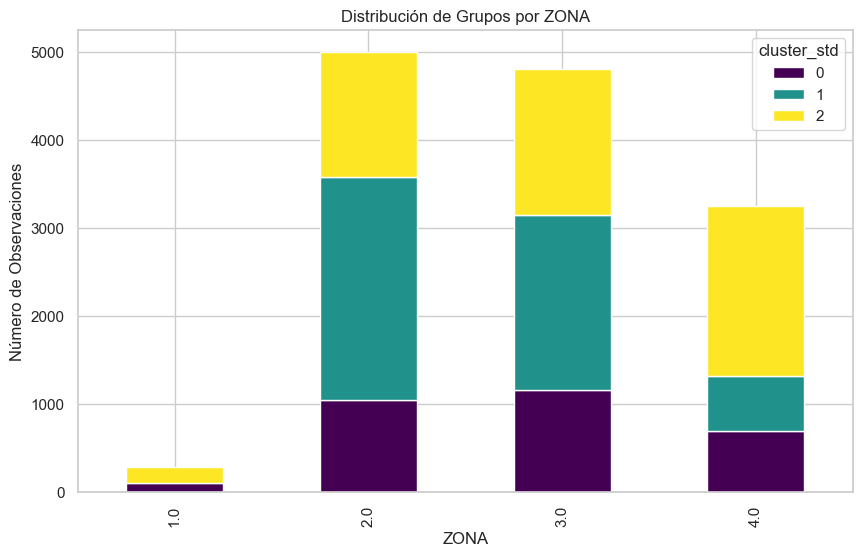

In [210]:
df_agrupado = data.groupby(['ZONA', 'cluster_std']).size().unstack()

# Configurar el estilo de seaborn
sns.set(style="whitegrid")

# Crear un gráfico de barras apiladas
df_agrupado.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')  # Puedes ajustar la paleta de colores según tu preferencia

# Añadir título y etiquetas a los ejes
plt.title('Distribución de Grupos por ZONA')
plt.xlabel('ZONA')
plt.ylabel('Número de Observaciones')

# Mostrar el gráfico
plt.show()

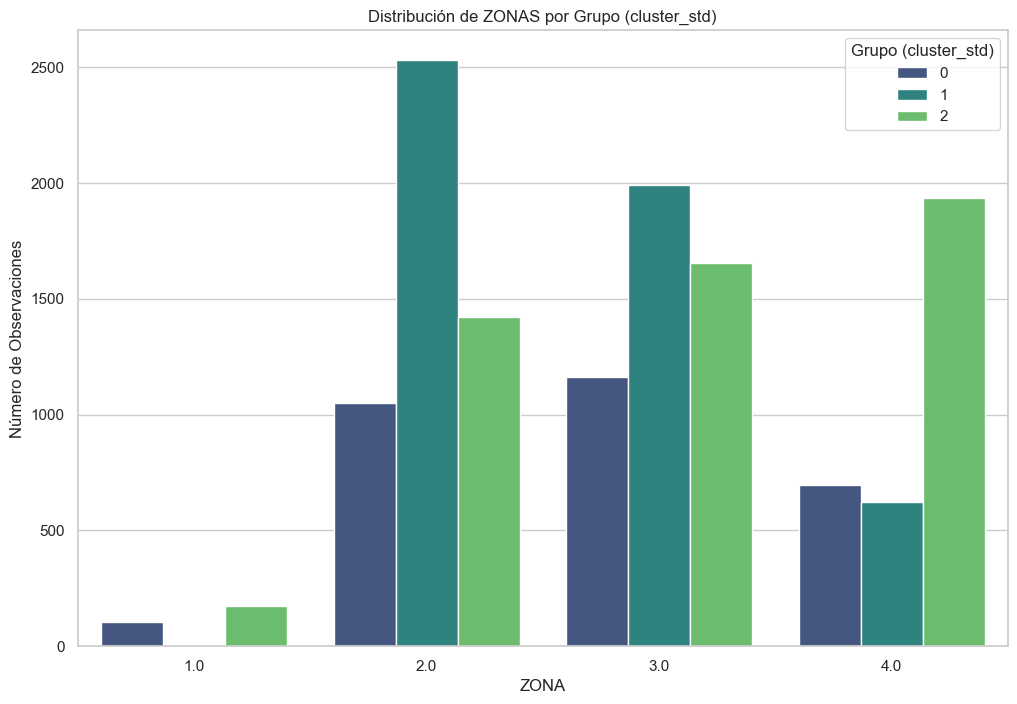

In [211]:
sns.set(style="whitegrid")

# Crear un gráfico de barras para cada cluster_std
plt.figure(figsize=(12, 8))
sns.countplot(x='ZONA', hue='cluster_std', data=data, palette='viridis')  # Ajusta la paleta de colores según tu preferencia

# Añadir título y etiquetas a los ejes
plt.title('Distribución de ZONAS por Grupo (cluster_std)')
plt.xlabel('ZONA')
plt.ylabel('Número de Observaciones')

# Mostrar la leyenda
plt.legend(title='Grupo (cluster_std)')

# Mostrar el gráfico
plt.show()

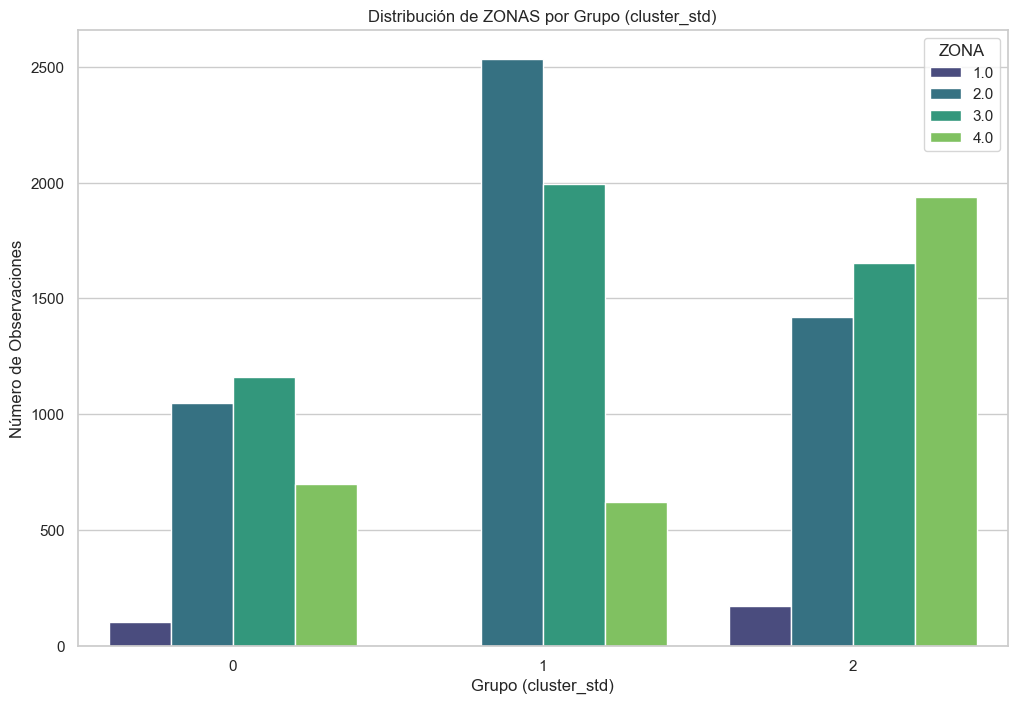

In [212]:
# Filtrar los registros donde 'ZONA' no es NaN
df_filtrado = data.dropna(subset=['ZONA'])

# Configurar el estilo de seaborn
sns.set(style="whitegrid")

# Crear un gráfico de barras apilado
plt.figure(figsize=(12, 8))
sns.countplot(x='cluster_std', hue='ZONA', data=df_filtrado, palette='viridis')  # Ajusta la paleta de colores según tu preferencia

# Añadir título y etiquetas a los ejes
plt.title('Distribución de ZONAS por Grupo (cluster_std)')
plt.xlabel('Grupo (cluster_std)')
plt.ylabel('Número de Observaciones')

# Mostrar el gráfico
plt.show()

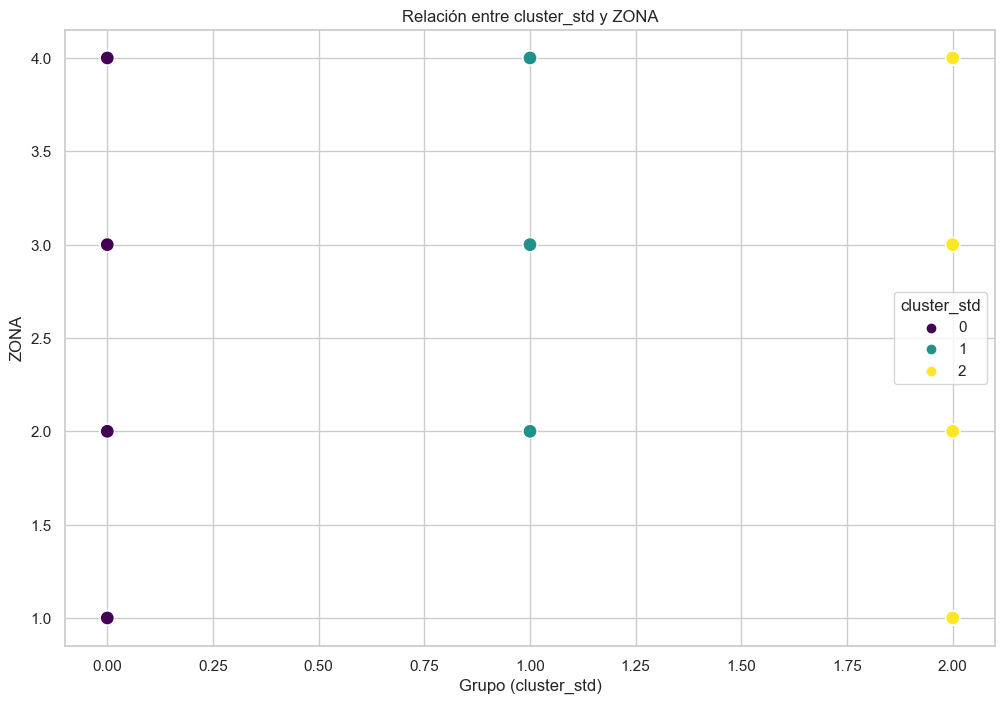

In [230]:
# Configurar el estilo de seaborn
sns.set(style="whitegrid")

# Crear un gráfico de dispersión
plt.figure(figsize=(12, 8))
sns.scatterplot(x='cluster_std', y='ZONA', data=df_filtrado, hue='cluster_std', palette='viridis', s=100)

# Añadir título y etiquetas a los ejes
plt.title('Relación entre cluster_std y ZONA')
plt.xlabel('Grupo (cluster_std)')
plt.ylabel('ZONA')

# Mostrar el gráfico
plt.show()

In [221]:
df_filtrado.head()

,Unnamed: 0,YEAR,UBIGEO,DOMINIO,ESTRATO,Registro_SUNARP_1,Registro_SUNARP_2,Asistencia_Tecnica_1,Asistencia_Tecnica_2,Asistencia_Tecnica_3,...,Categoria_I-3,Categoria_I-4,Proyectos_inversion,ZONA,cluster_std,region_y,provincia_y,distrito_y,latitud,longitud
0,0,2018,10202,7,7,0,0,0,24,0,...,3.0,0.0,0.0,2.0,1,AMAZONAS,BAGUA,ARAMANGO,-5.4164,-78.4378
1,1,2018,10201,7,4,13,9,6,45,12,...,2.0,0.0,0.0,2.0,1,AMAZONAS,BAGUA,BAGUA,-5.6389,-78.5311
2,2,2018,10203,7,6,2,3,0,21,2,...,1.0,0.0,0.0,2.0,1,AMAZONAS,BAGUA,COPALLIN,-5.6750,-78.4231
3,3,2018,10205,7,7,1,0,0,36,1,...,5.0,0.0,0.0,2.0,1,AMAZONAS,BAGUA,IMAZA,-5.1636,-78.2889
4,4,2018,10206,7,6,2,4,0,17,1,...,0.0,0.0,0.0,2.0,1,AMAZONAS,BAGUA,LA PECA,-5.6119,-78.4369


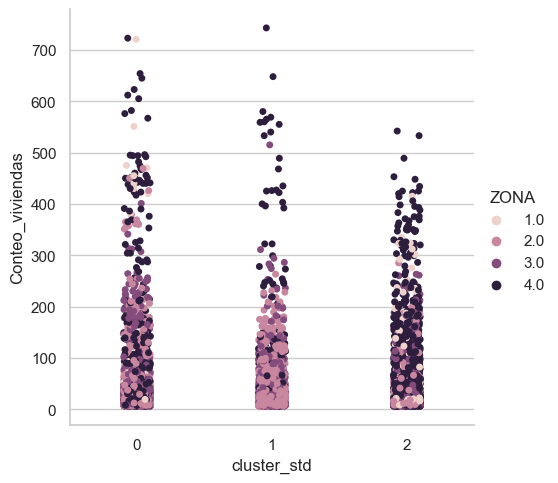

In [233]:
sns.catplot(x='cluster_std', y ='Conteo_viviendas', data=df_filtrado,hue='ZONA')
plt.show()

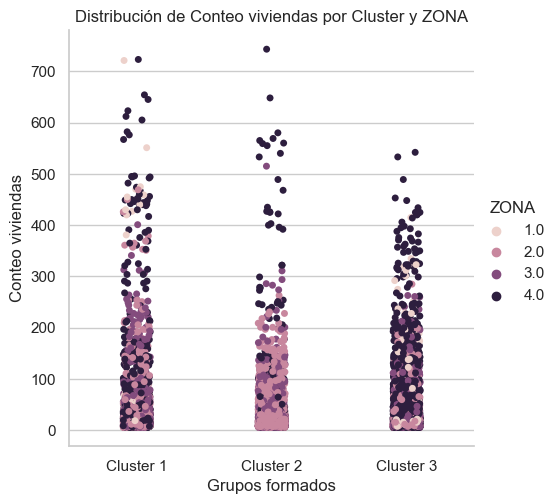

In [254]:
sns.set(style="whitegrid")

# Crear un gráfico de catplot
g = sns.catplot(x='cluster_std', y ='Conteo_viviendas', data=df_filtrado, hue='ZONA')

# Cambiar las etiquetas del eje x
g.set_xticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3'])

# Añadir título y etiquetas a los ejes
plt.title('Distribución de Conteo viviendas por Cluster y ZONA')
plt.xlabel('Grupos formados')
plt.ylabel('Conteo viviendas')

plt.savefig('conteo_zona.png', bbox_inches='tight')

# Mostrar el gráfico
plt.show()

In [225]:
df_filtrado.columns

Index(['Unnamed: 0', 'YEAR', 'UBIGEO', 'DOMINIO', 'ESTRATO',
       'Registro_SUNARP_1', 'Registro_SUNARP_2', 'Asistencia_Tecnica_1',
       'Asistencia_Tecnica_2', 'Asistencia_Tecnica_3', 'Licencia_1',
       'Licencia_2', 'Licencia_3', 'Tipo_Vivienda_1', 'Tipo_Vivienda_2',
       'Tipo_Vivienda_3', 'Tipo_Vivienda_4', 'Tipo_Vivienda_5',
       'Tipo_Vivienda_6', 'Tipo_Vivienda_7', 'Tipo_Vivienda_8',
       'Pared_material_1', 'Pared_material_2', 'Pared_material_3',
       'Pared_material_4', 'Pared_material_5', 'Pared_material_6',
       'Pared_material_7', 'Pared_material_8', 'Piso_material_1',
       'Piso_material_2', 'Piso_material_3', 'Piso_material_4',
       'Piso_material_5', 'Piso_material_6', 'Piso_material_7',
       'Techo_material_1', 'Techo_material_2', 'Techo_material_3',
       'Techo_material_4', 'Techo_material_5', 'Techo_material_6',
       'Techo_material_7', 'Techo_material_8', 'Nivel_propiedad_vivienda_1',
       'Nivel_propiedad_vivienda_2', 'Nivel_propiedad_viv

In [226]:
df_filtrado.Conteo.unique()

array([ 0.,  1.,  2., 12.,  3.,  4.,  8.,  6.,  9., 18.,  7.,  5., 50.,
       32., 48., 13., 26., 20., 11., 14., 10., 15., 17., 19., 16., 21.,
       24.])

# Parte de Machine Learning

In [13]:
data.dtypes

Unnamed: 0               int64
YEAR                     int64
UBIGEO                   int64
DOMINIO                  int64
ESTRATO                  int64
                        ...   
Proyectos_inversion    float64
ZONA                   float64
cluster_std              int64
latitud                float64
longitud               float64
Length: 72, dtype: object

In [15]:
data.columns

Index(['Unnamed: 0', 'YEAR', 'UBIGEO', 'DOMINIO', 'ESTRATO',
       'Registro_SUNARP_SI', 'Registro_SUNARP_NO', 'Asistencia_Tecnica_SI',
       'Asistencia_Tecnica_NO', 'Asistencia_Tecnica_NOSABE', 'Licencia_SI',
       'Licencia_NO', 'Licencia_NOSABE', 'Tipo_casa_Independiente',
       'Tipo_casa_Departamento', 'Tipo_casa_Quinta', 'Tipo_casa_Vecindad',
       'Tipo_casa_Choza', 'Tipo_casa_Improvisada', 'Tipo_casa_No_habitable',
       'Tipo_casa_Otro', 'Pared_Ladrillo', 'Pared_Piedra_sillar',
       'Pared_Adobe', 'Pared_Tapia', 'Pared_Quincha', 'Pared_Piedra_barro',
       'Pared_Madera', 'Pared_Tripley', 'Piso_MaderaPulida',
       'Piso_LaminasAsfalticas', 'Piso_Losetas', 'Piso_Madera', 'Piso_Cemento',
       'Piso_Tierra', 'Piso_Otro', 'Techo_Concreto', 'Techo_Madera',
       'Techo_Tejas', 'Techo_Calamina', 'Techo_Caña', 'Techo_Triplay',
       'Techo_Paja', 'Techo_Otro', 'Nivel_Casa_Alquilada',
       'Nivel_Casa_PropiaPagada', 'Nivel_Casa_PropiaInvasion',
       'Nivel_Casa_Pro

In [18]:
Nombres = ['Unnamed: 0', 'UBIGEO', 'latitud', 'longitud']  #'YEAR'

In [19]:
# Eliminar las columnas
df = data.drop(Nombres, axis=1)

In [20]:
df.dtypes

YEAR                     int64
DOMINIO                  int64
ESTRATO                  int64
Registro_SUNARP_SI       int64
Registro_SUNARP_NO       int64
                        ...   
Categoria_I-3          float64
Categoria_I-4          float64
Proyectos_inversion    float64
ZONA                   float64
cluster_std              int64
Length: 68, dtype: object

In [21]:
df.shape

(13344, 68)

In [22]:
columnnas_cat = df.select_dtypes(include=['object']).columns
list(columnnas_cat)

['region', 'provincia', 'distrito', 'Key']

In [23]:
df = df.drop(list(columnnas_cat), axis=1)

In [24]:
columnnas_cat = df.select_dtypes(include=['object']).columns
columnnas_cat

Index([], dtype='object')

In [26]:
# Dimensiones de los datos
df.shape

(13344, 64)

In [27]:
# Eliminar columnas con NaN
df = df.dropna(axis=1)

In [28]:
df.shape

(13344, 63)

In [29]:
df[df['cluster_std']==0].shape

(3012, 63)

In [30]:
# Obtener todas las columnas necesarias para el entrenamiento
X = df.drop('cluster_std', axis=1).copy()
y = df['cluster_std'].copy()

In [31]:
y.unique()

array([1, 2, 0], dtype=int64)

In [32]:
# realiza el train-test split
valid_size = 0.20    # proporcion de muestras para validacion
seed = 7   # semilla para el generador aleatorio (para reproductibilidad)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=valid_size, random_state=seed)

print('Training: %d ejemplos. Validation: %d ejemplos' % (len(y_train), len(y_valid)))

Training: 10675 ejemplos. Validation: 2669 ejemplos


In [33]:
y_valid.shape

(2669,)

## Distribucion del conjunto

In [34]:
# Cluster 1
y_valid_zeros = np.count_nonzero(y_valid == 0)
y_train_zeros = np.count_nonzero(y_train == 0)
print("Número de elementos iguales a 0 en y_train:", y_train_zeros)
print("Número de elementos iguales a 0 en y_valid:", y_valid_zeros)

Número de elementos iguales a 0 en y_train: 2404
Número de elementos iguales a 0 en y_valid: 608


In [35]:
# Cluster 2
y_valid_zeros = np.count_nonzero(y_valid == 1)
y_train_zeros = np.count_nonzero(y_train == 1)
print("Número de elementos iguales a 0 en y_train:", y_train_zeros)
print("Número de elementos iguales a 0 en y_valid:", y_valid_zeros)

Número de elementos iguales a 0 en y_train: 4127
Número de elementos iguales a 0 en y_valid: 1019


In [36]:
# Cluster 3
y_valid_zeros = np.count_nonzero(y_valid == 2)
y_train_zeros = np.count_nonzero(y_train == 2)
print("Número de elementos iguales a 0 en y_train:", y_train_zeros)
print("Número de elementos iguales a 0 en y_valid:", y_valid_zeros)

Número de elementos iguales a 0 en y_train: 4144
Número de elementos iguales a 0 en y_valid: 1042


In [39]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

In [40]:
# Definimos el pool de algoritmos de ensamble a evaluar
algos = []
#algos.append(('LR', LogisticRegression()))
algos.append(('SVM', SVC(probability=True)))
algos.append(('AdaBoost', AdaBoostClassifier())) #secuencial (Boosting)
algos.append(('GradientBoosting', GradientBoostingClassifier())) #secuencial (Boosting)
algos.append(('RandomForest', RandomForestClassifier())) #paralelo (Bagging)
algos.append(('ExtraTrees',ExtraTreesClassifier())) #paralelo (Bagging)

In [42]:
# Definir la métrica adicional
additional_metrics = ['precision', 'roc_auc']

# Definir la estrategia de validación cruzada
kfold = KFold(n_splits=5, random_state=42, shuffle=True)

for algoname, algo in algos:
    # Validación cruzada en el conjunto de entrenamiento
    cv_results = cross_val_score(algo, X_train, y_train, cv=kfold, scoring='accuracy')
    
    # Entrenamiento en todo el conjunto de entrenamiento
    algo.fit(X_train, y_train)
    
    # Predicciones en el conjunto de prueba
    y_pred = algo.predict(X_valid)
    
    # Calcular métricas adicionales
    precision = precision_score(y_valid, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_valid, algo.predict_proba(X_valid), average='weighted', multi_class='ovr')
    
    # Mostrar los resultados
    print("{}: Train CV Accuracy: {} ({}) | Test Accuracy: {} | Precision: {} | ROC AUC: {}".format(algoname, cv_results.mean(), cv_results.std(), accuracy_score(y_valid, y_pred), precision, roc_auc))

SVM: Train CV Accuracy: 0.4118032786885246 (0.010841447313670668) | Test Accuracy: 0.4121393780442113 | Precision: 0.5045621669230518 | ROC AUC: 0.7079001413908491
AdaBoost: Train CV Accuracy: 0.6770023419203748 (0.009956219395287244) | Test Accuracy: 0.6927688272761334 | Precision: 0.6953020893128053 | ROC AUC: 0.8407894365559109
GradientBoosting: Train CV Accuracy: 0.8156440281030445 (0.006046328641912843) | Test Accuracy: 0.8171599850131135 | Precision: 0.8162603467779709 | ROC AUC: 0.9436138604806883
RandomForest: Train CV Accuracy: 0.8805620608899298 (0.012519092363307274) | Test Accuracy: 0.8924690895466467 | Precision: 0.8925773345366639 | ROC AUC: 0.9761644177326968
ExtraTrees: Train CV Accuracy: 0.892927400468384 (0.008685209919624716) | Test Accuracy: 0.8995878606219558 | Precision: 0.8994710069895046 | ROC AUC: 0.9788873560848432


In [150]:
from sklearn.metrics import confusion_matrix

for algoname, algo in algos:
    # Validación cruzada en el conjunto de entrenamiento
    cv_results = cross_val_score(algo, X_train, y_train, cv=kfold, scoring='accuracy')
    
    # Entrenamiento en todo el conjunto de entrenamiento
    algo.fit(X_train, y_train)
    
    # Predicciones en el conjunto de prueba
    y_pred = algo.predict(X_valid)
    
    # Calcula la precisión en el conjunto de prueba
    test_accuracy = accuracy_score(y_valid, y_pred)
    
    # Calcula la matriz de confusión
    cm = confusion_matrix(y_valid, y_pred)
    
    # Muestra los resultados y la matriz de confusión
    print("{}: Train CV Accuracy: {} ({}) | Test Accuracy: {}".format(algoname, cv_results.mean(), cv_results.std(), test_accuracy))
    print("Confusion Matrix:")
    print(cm)

SVM: Train CV Accuracy: 0.994753658442411 (0.0038214318664038143) | Test Accuracy: 1.0
Confusion Matrix:
[[ 608    0    0]
 [   0 1019    0]
 [   0    0 1042]]
AdaBoost: Train CV Accuracy: 1.0 (0.0) | Test Accuracy: 1.0
Confusion Matrix:
[[ 608    0    0]
 [   0 1019    0]
 [   0    0 1042]]
GradientBoosting: Train CV Accuracy: 1.0 (0.0) | Test Accuracy: 1.0
Confusion Matrix:
[[ 608    0    0]
 [   0 1019    0]
 [   0    0 1042]]
RandomForest: Train CV Accuracy: 1.0 (0.0) | Test Accuracy: 1.0
Confusion Matrix:
[[ 608    0    0]
 [   0 1019    0]
 [   0    0 1042]]
ExtraTrees: Train CV Accuracy: 0.9991569523568827 (0.0006557317700068948) | Test Accuracy: 0.9985013113525665
Confusion Matrix:
[[ 606    0    2]
 [   0 1017    2]
 [   0    0 1042]]


In [151]:
X.shape

(13344, 62)

In [43]:
X.shape

(13344, 62)

In [58]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definir la arquitectura de la red neuronal
model = models.Sequential()

# Capa de entrada
model.add(layers.InputLayer(input_shape=(62,)))

# Capas ocultas
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))  # Añadir dropout para regularización
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dropout(0.5))  # Añadir dropout para regularización
model.add(layers.Dense(32, activation='relu'))

# Capa de salida
model.add(layers.Dense(3, activation='softmax'))  # 3 clases: 0, 1, 2

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Mostrar la arquitectura del modelo
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 128)               8064      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 32)                4128      
                                                                 
 dense_15 (Dense)            (None, 3)                 99        
                                                                 
Total params: 12291 (48.01 KB)
Trainable params: 12291 (48.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_valid, y_valid))

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_valid, y_valid)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

Epoch 1/50
334/334 [==============================] - 1s 2ms/step - loss: 23.3369 - accuracy: 0.3750 - val_loss: 7.2538 - val_accuracy: 0.3987
Epoch 2/50
334/334 [==============================] - 1s 2ms/step - loss: 3.7282 - accuracy: 0.4225 - val_loss: 1.4058 - val_accuracy: 0.4076
Epoch 3/50
334/334 [==============================] - 1s 2ms/step - loss: 1.6836 - accuracy: 0.4523 - val_loss: 0.9411 - val_accuracy: 0.5736
Epoch 4/50
334/334 [==============================] - 1s 2ms/step - loss: 1.2539 - accuracy: 0.4841 - val_loss: 1.0081 - val_accuracy: 0.5215
Epoch 5/50
334/334 [==============================] - 1s 2ms/step - loss: 1.2342 - accuracy: 0.4912 - val_loss: 1.0457 - val_accuracy: 0.5894
Epoch 6/50
334/334 [==============================] - 1s 2ms/step - loss: 1.1768 - accuracy: 0.5001 - val_loss: 0.9846 - val_accuracy: 0.4605
Epoch 7/50
334/334 [==============================] - 1s 2ms/step - loss: 1.0577 - accuracy: 0.5264 - val_loss: 0.8995 - val_accuracy: 0.5871
Epoch

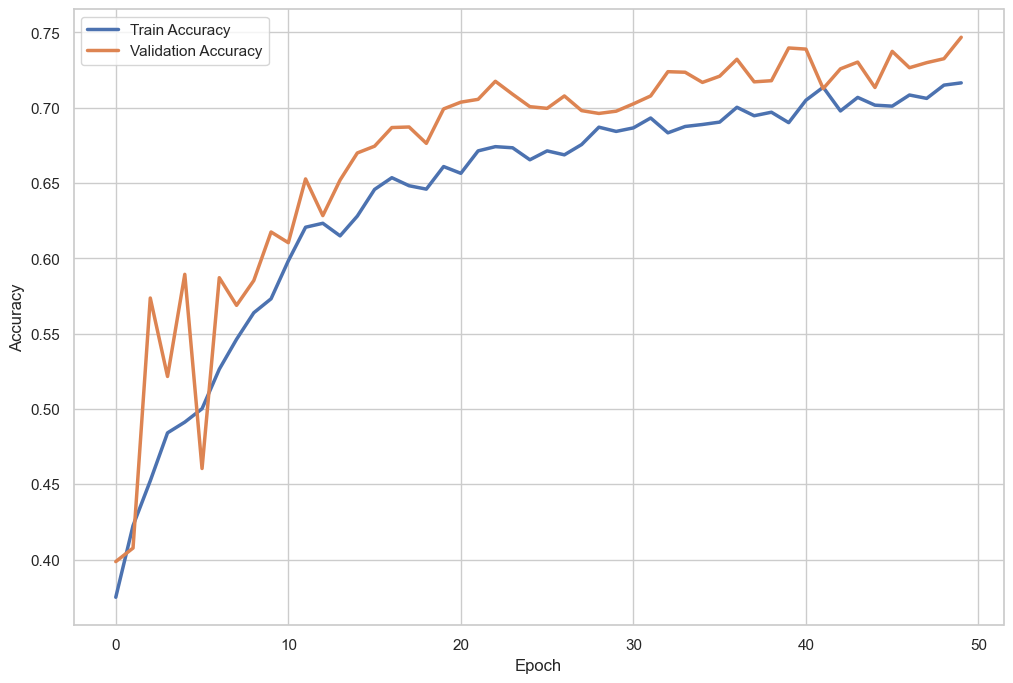

In [61]:
# Visualizar la curva de aprendizaje
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('Des_mlp.png', bbox_inches='tight')

plt.show()

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

84/84 [==============================] - 0s 995us/step


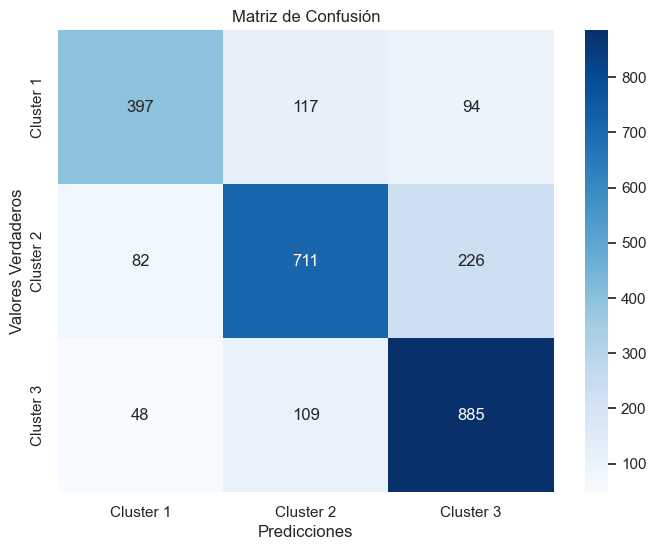

In [71]:
y_pred = model.predict(X_valid)


y_pred_classes = np.argmax(y_pred, axis=1)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_valid, y_pred_classes)

# Plotear la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cluster 1','Cluster 2','Cluster 3'], yticklabels=['Cluster 1','Cluster 2','Cluster 3'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')

plt.savefig('m_conf.png', bbox_inches='tight')

plt.show()